Examine ripple rate changes from MAZE to reMAZE to assess whether a weaker memory induces higher ripple rate (and potentially higher rate of replay).

### Imports

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        # plot_dir = Path('/data/Clustering/plots')
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Manuscripts/SleepDeprivationDrift/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as sstats
import pingouin as pg
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects
from stats_utils import bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()

In [5]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette(as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])


### Load in SWR data

In [6]:
sess = sessions[0]

rate_df = []
for ids, sess in enumerate(sessions):
    maze = sess.paradigm['maze'].flatten()
    remaze = sess.paradigm['re-maze'].flatten()
    
    maze_ripples = sess.ripple.time_slice(*maze)
    remaze_ripples = sess.ripple.time_slice(*remaze)
    
    maze_rate = maze_ripples.n_epochs / np.diff(maze)[0]
    remaze_rate = remaze_ripples.n_epochs / np.diff(remaze)[0]

    maze_pbes = sess.pbe.time_slice(*maze)
    remaze_pbes = sess.pbe.time_slice(*remaze)

    maze_pbe_rate = maze_pbes.n_epochs / np.diff(maze)[0]
    remaze_pbe_rate = remaze_pbes.n_epochs / np.diff(remaze)[0]

    for sname, rpl_rate, pbe_rate in zip(["MAZE", "reMAZE"], [maze_rate, remaze_rate], [maze_pbe_rate, remaze_pbe_rate]):
        rate_df.append(pd.DataFrame({"sid": ids, "animal": sess.animal.name, "day": sess.animal.day, "grp": sess.tag,
                                     "session": sname, "ripple rate (Hz)": rpl_rate, "PBE rate (Hz)": pbe_rate},
                                     index=[ids]))

rpl_rate_df = pd.concat(rate_df, axis=0, ignore_index=False)

ripple rate (Hz): NSD
               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  0.697765    6   two-sided  0.511444  [-0.28, 0.5]  0.493394  0.604   

           power  
T-test  0.091156  
ripple rate (Hz): SD
              T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.89025    8   two-sided  0.399312  [-0.14, 0.32]  0.563043  0.626   

           power  
T-test  0.123518  
PBE rate (Hz): NSD
              T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.69857    6   two-sided  0.035644  [0.01, 0.23]  1.908177  2.338   

           power  
T-test  0.617092  
PBE rate (Hz): SD
               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test  0.740853    8   two-sided  0.47996  [-0.07, 0.14]  0.468557  0.583   

           power  
T-test  0.100532  


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)


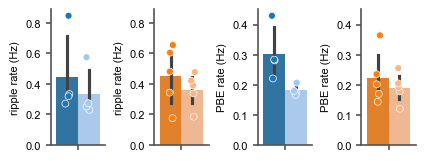

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


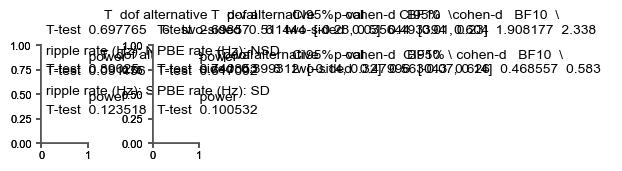

In [13]:
from neuropy.utils.plot_util import match_axis_lims
fig = Fig(16, 12)
figs = Fig(16, 12)
# fig, axs = plt.subplots(1, 4, figsize=(6, 3))
for idm, metric in enumerate(["ripple rate (Hz)", "PBE rate (Hz)"]):

    ax_metric = []
    for idg, grp in enumerate(["NSD", "SD"]):
        ax = fig.subplot(fig.gs[0:2, idm * 2 + idg])
        ax_metric.append(ax)
        axstat = figs.subplot(figs.gs[2:4, idm * 2])
        df_grp = rpl_rate_df[rpl_rate_df.grp == grp]
        sns.barplot(data=df_grp, y=metric, hue="session", ax=ax, palette=cmap3[(idg*2):(idg+1)*2], legend=False)
        sns.stripplot(data=df_grp, y=metric, hue="session", linewidth=0.5, edgecolor="w", palette=cmap3[(idg*2):(idg+1)*2], 
                      dodge=True, legend=False, ax=ax)
        a.set_title(grp)
    match_axis_lims(ax_metric, "y")

    idy = 0.9
    for grp in ["NSD", "SD"]:
        print(f"{metric}: {grp}")
        df_grp = rpl_rate_df[rpl_rate_df.grp == grp]
        print(pg.ttest(df_grp[df_grp.session == "MAZE"][metric].values, df_grp[df_grp.session == "reMAZE"][metric].values))

        axstat.text(0.1, idy, f"{metric}: {grp}")
        idy -= 0.2
        axstat.text(0.1, idy, pg.ttest(df_grp[df_grp.session == "MAZE"][metric].values, df_grp[df_grp.session == "reMAZE"][metric].values))
        idy -= 0.2
sns.despine(fig=fig.fig)
fig.savefig(plot_dir / "SWR_PBE_rate.pdf")

<Axes: xlabel='grp', ylabel='PBE rate (Hz)'>

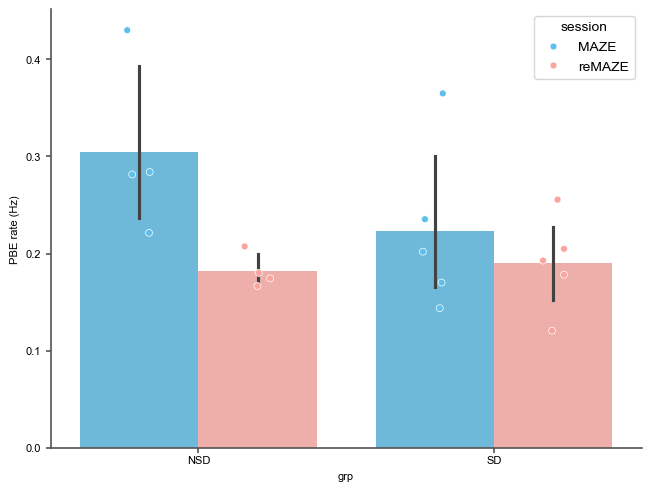

In [14]:
_, ax = plt.subplots()
sns.barplot(data=rpl_rate_df, x="grp", y="PBE rate (Hz)", hue="session", ax=ax, legend=False)
sns.stripplot(data=rpl_rate_df, x="grp", y="PBE rate (Hz)", hue="session", linewidth=0.5, edgecolor="w", dodge=True, ax=ax)

## NRK TODO:
1) Update to look at candidate PBEs? Or better, ripples with coincident PBEs only?